<a href="https://colab.research.google.com/github/imabari/covid19-data/blob/master/aichi/aichi_ocr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!add-apt-repository ppa:alex-p/tesseract-ocr -y

!apt update

!apt install tesseract-ocr
!apt install libtesseract-dev

!tesseract -v

!apt install tesseract-ocr-jpn  tesseract-ocr-jpn-vert
!apt install tesseract-ocr-script-jpan tesseract-ocr-script-jpan-vert

!tesseract --list-langs
!pip install pytesseract

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ Packages [95.7 kB]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Get:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release [564 B]
Get:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release.gpg [833 B]
Get:8 http://ppa.launchpad.net/alex-p/tesseract-ocr/ubuntu bionic InRelease [15.4 kB]
Get:9 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:11 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:12 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Packa

In [2]:
import pathlib
import re
from urllib.parse import urljoin

import cv2
import numpy as np
import pytesseract
import requests
from bs4 import BeautifulSoup

In [3]:
# スクレイピング
url = "https://www.pref.aichi.jp/site/covid19-aichi/"

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; WOW64; Trident/7.0; rv:11.0) like Gecko",
}

r = requests.get(url, headers=headers)
r.raise_for_status()

In [4]:
soup = BeautifulSoup(r.content, "html5lib")
src = soup.find("img", alt=re.compile("検査陽性者$")).get("src")

In [5]:
link = urljoin(url, src)
print(link)

# ダウンロード
def get_file(url, dir="."):

    r = requests.get(url)

    p = pathlib.Path(dir, pathlib.PurePath(url).name)
    p.parent.mkdir(parents=True, exist_ok=True)

    with p.open(mode="wb") as fw:
        fw.write(r.content)

    return p

jpg_path = get_file(link)

https://www.pref.aichi.jp/uploaded/image/243084.jpg


In [6]:
from google.colab.patches import cv2_imshow

In [7]:
src = cv2.imread(str(jpg_path))[2:-2, 2:-2]

# ファイルを選択

In [8]:
# src = cv2.imread("2020083118.png")[2:-2, 2:-2]

In [9]:
h, w = src.shape[:2]
wide = int(1500 / w * h)

large = cv2.resize(src, (1500, wide))
gray = cv2.cvtColor(large, cv2.COLOR_BGR2GRAY)

In [10]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
dilated = cv2.dilate(gray, kernel, iterations=1)
diff = cv2.absdiff(dilated, gray)

In [11]:
contour = cv2.bitwise_not(diff)

In [12]:
contour[contour > 200] = 255
# contour[contour < 100] = 0

In [13]:
if w < 800:
    contour = cv2.inRange(large, (150, 120, 130), (255, 255, 255))

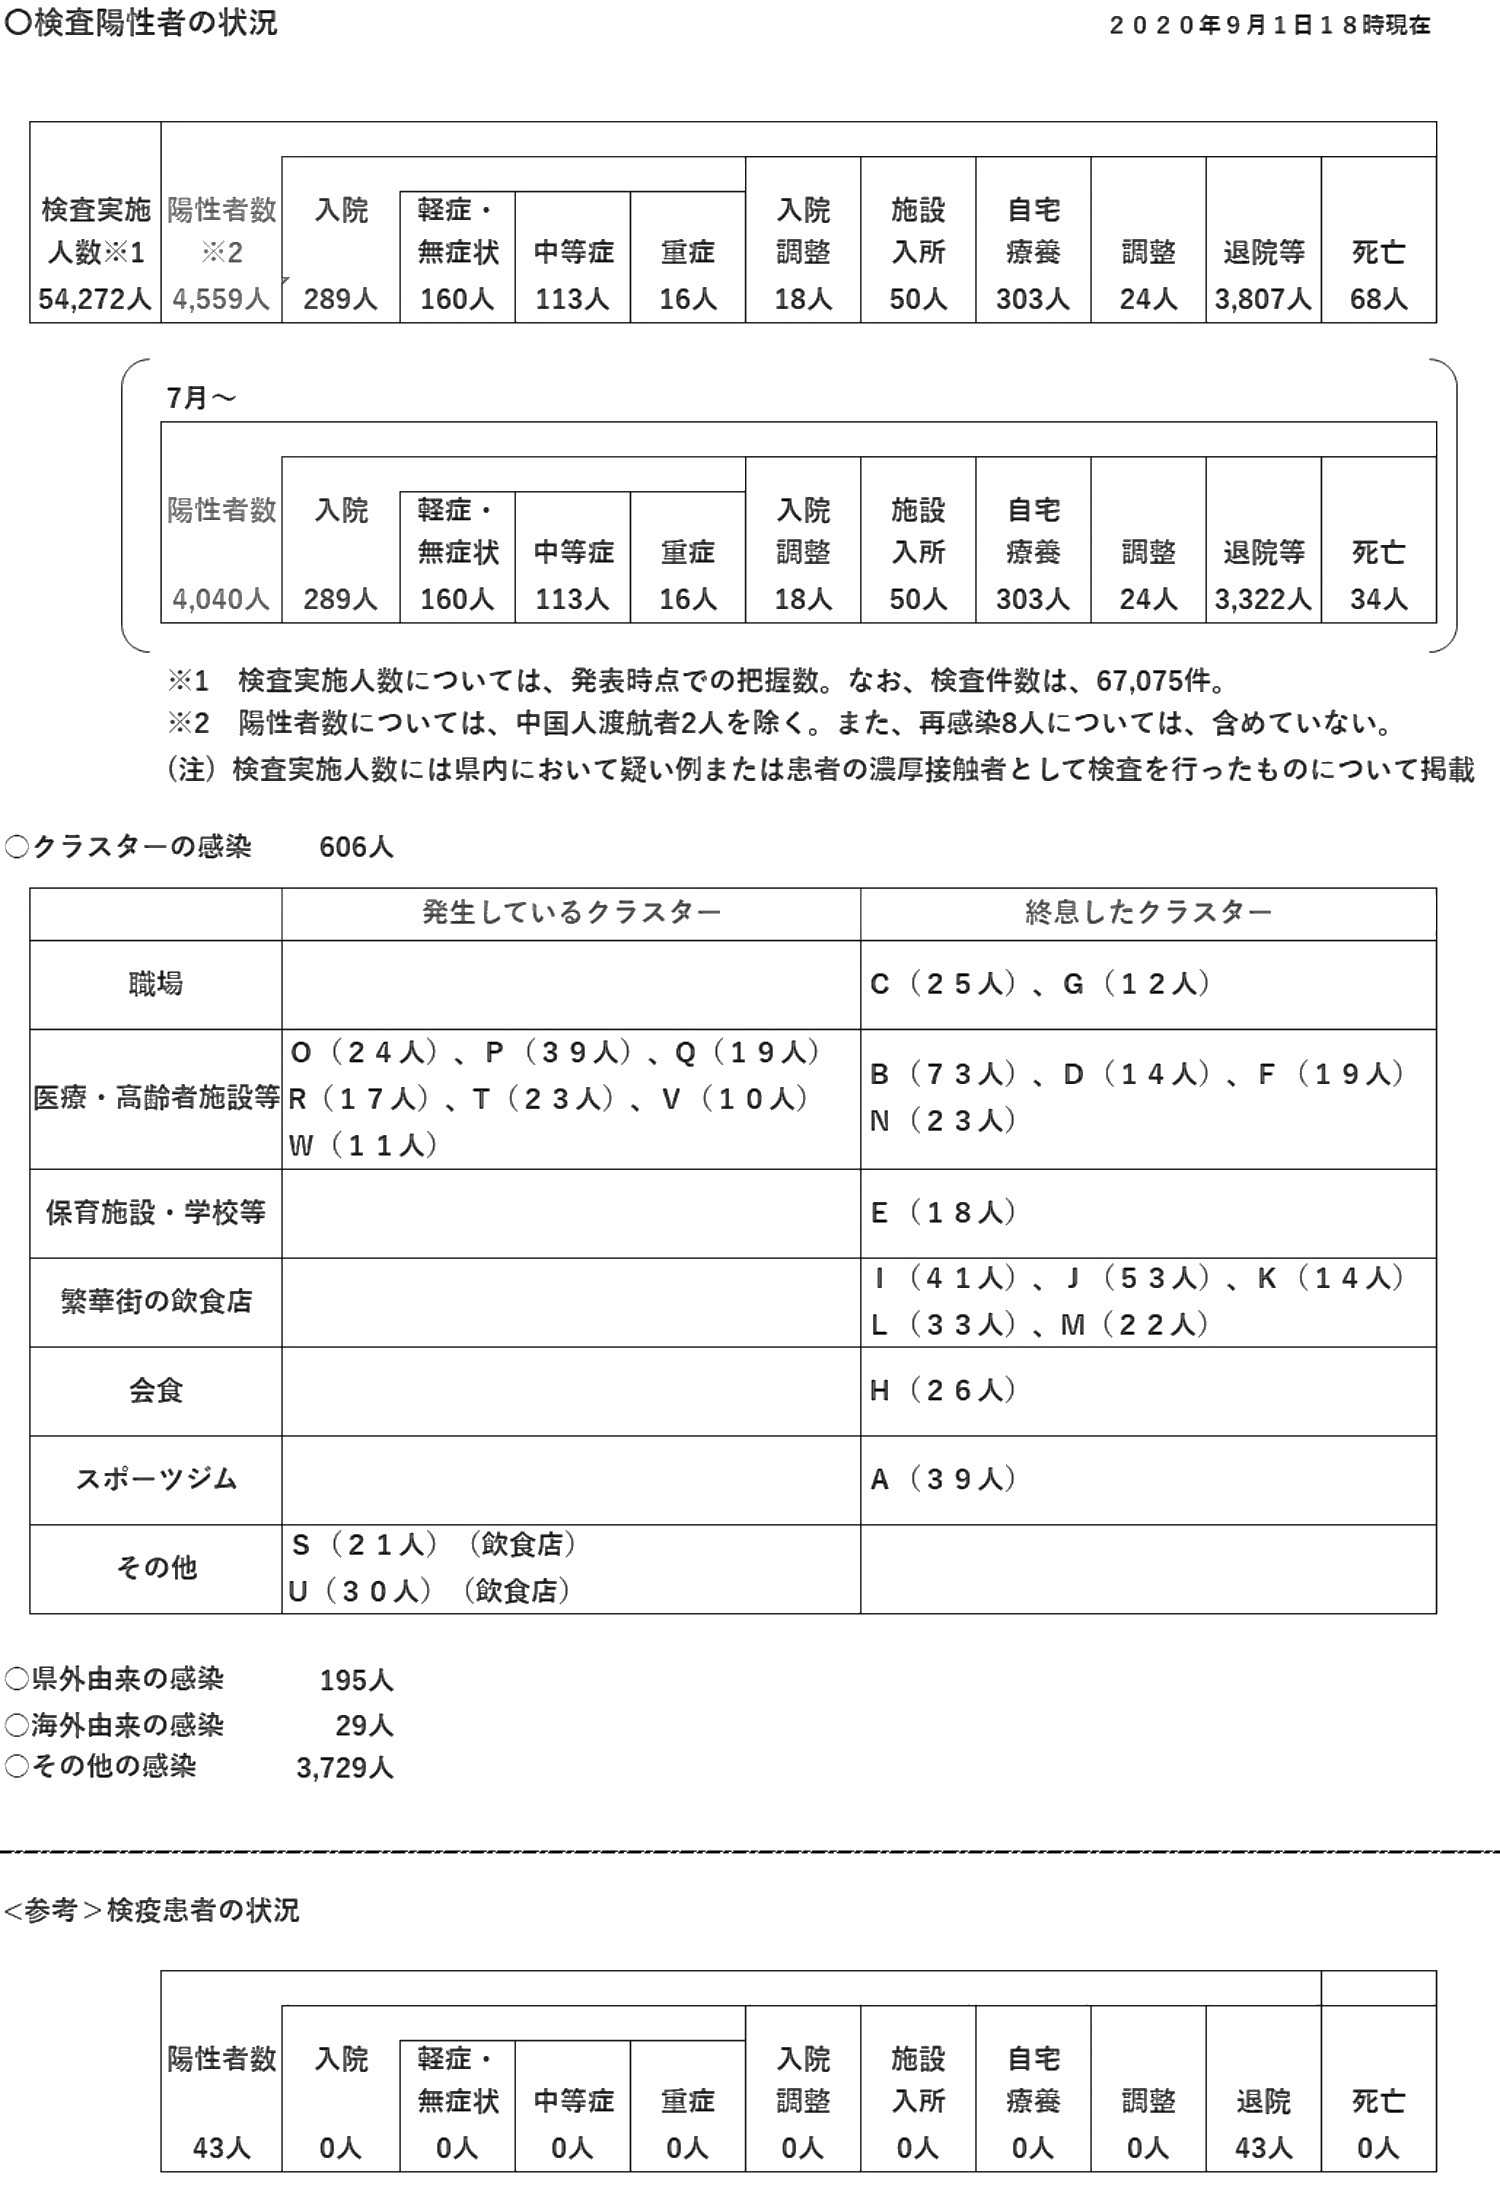

In [14]:
cv2_imshow(contour)

In [15]:
# 楕円形カーネル
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))

# モルフォロジー勾配（物体の境界線）
grad = cv2.morphologyEx(gray, cv2.MORPH_GRADIENT, kernel)

# 二値化
_, bw = cv2.threshold(grad, 0.0, 255.0, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

# 矩形カーネル
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 1))

# ノイズ除去
connected = cv2.morphologyEx(bw, cv2.MORPH_CLOSE, kernel)

# cv2.RETR_EXTERNAL 輪郭
# cv2.CHAIN_APPROX_NONE 輪郭全点の情報を保持

contours, hierarchy = cv2.findContours(
    connected.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE
)

mask = np.zeros(bw.shape, dtype=np.uint8)

rects = []

for idx in range(len(contours)):
    # 外接矩形
    x, y, w, h = cv2.boundingRect(contours[idx])

    mask[y : y + h, x : x + w] = 0

    # 輪郭を描画
    cv2.drawContours(mask, contours, idx, (255, 255, 255), -1)

    # 面積割合
    r = float(cv2.countNonZero(mask[y : y + h, x : x + w])) / (w * h)

    # 面積、縦・横長さ
    if r > 0.45 and w > 1000 and h > 8:
        rects.append((x, x + w, y, y + h))

# Y下、X左でソート
rects = sorted(rects, key=lambda x: (x[3], x[0]))

# 個数
print(len(rects))

4


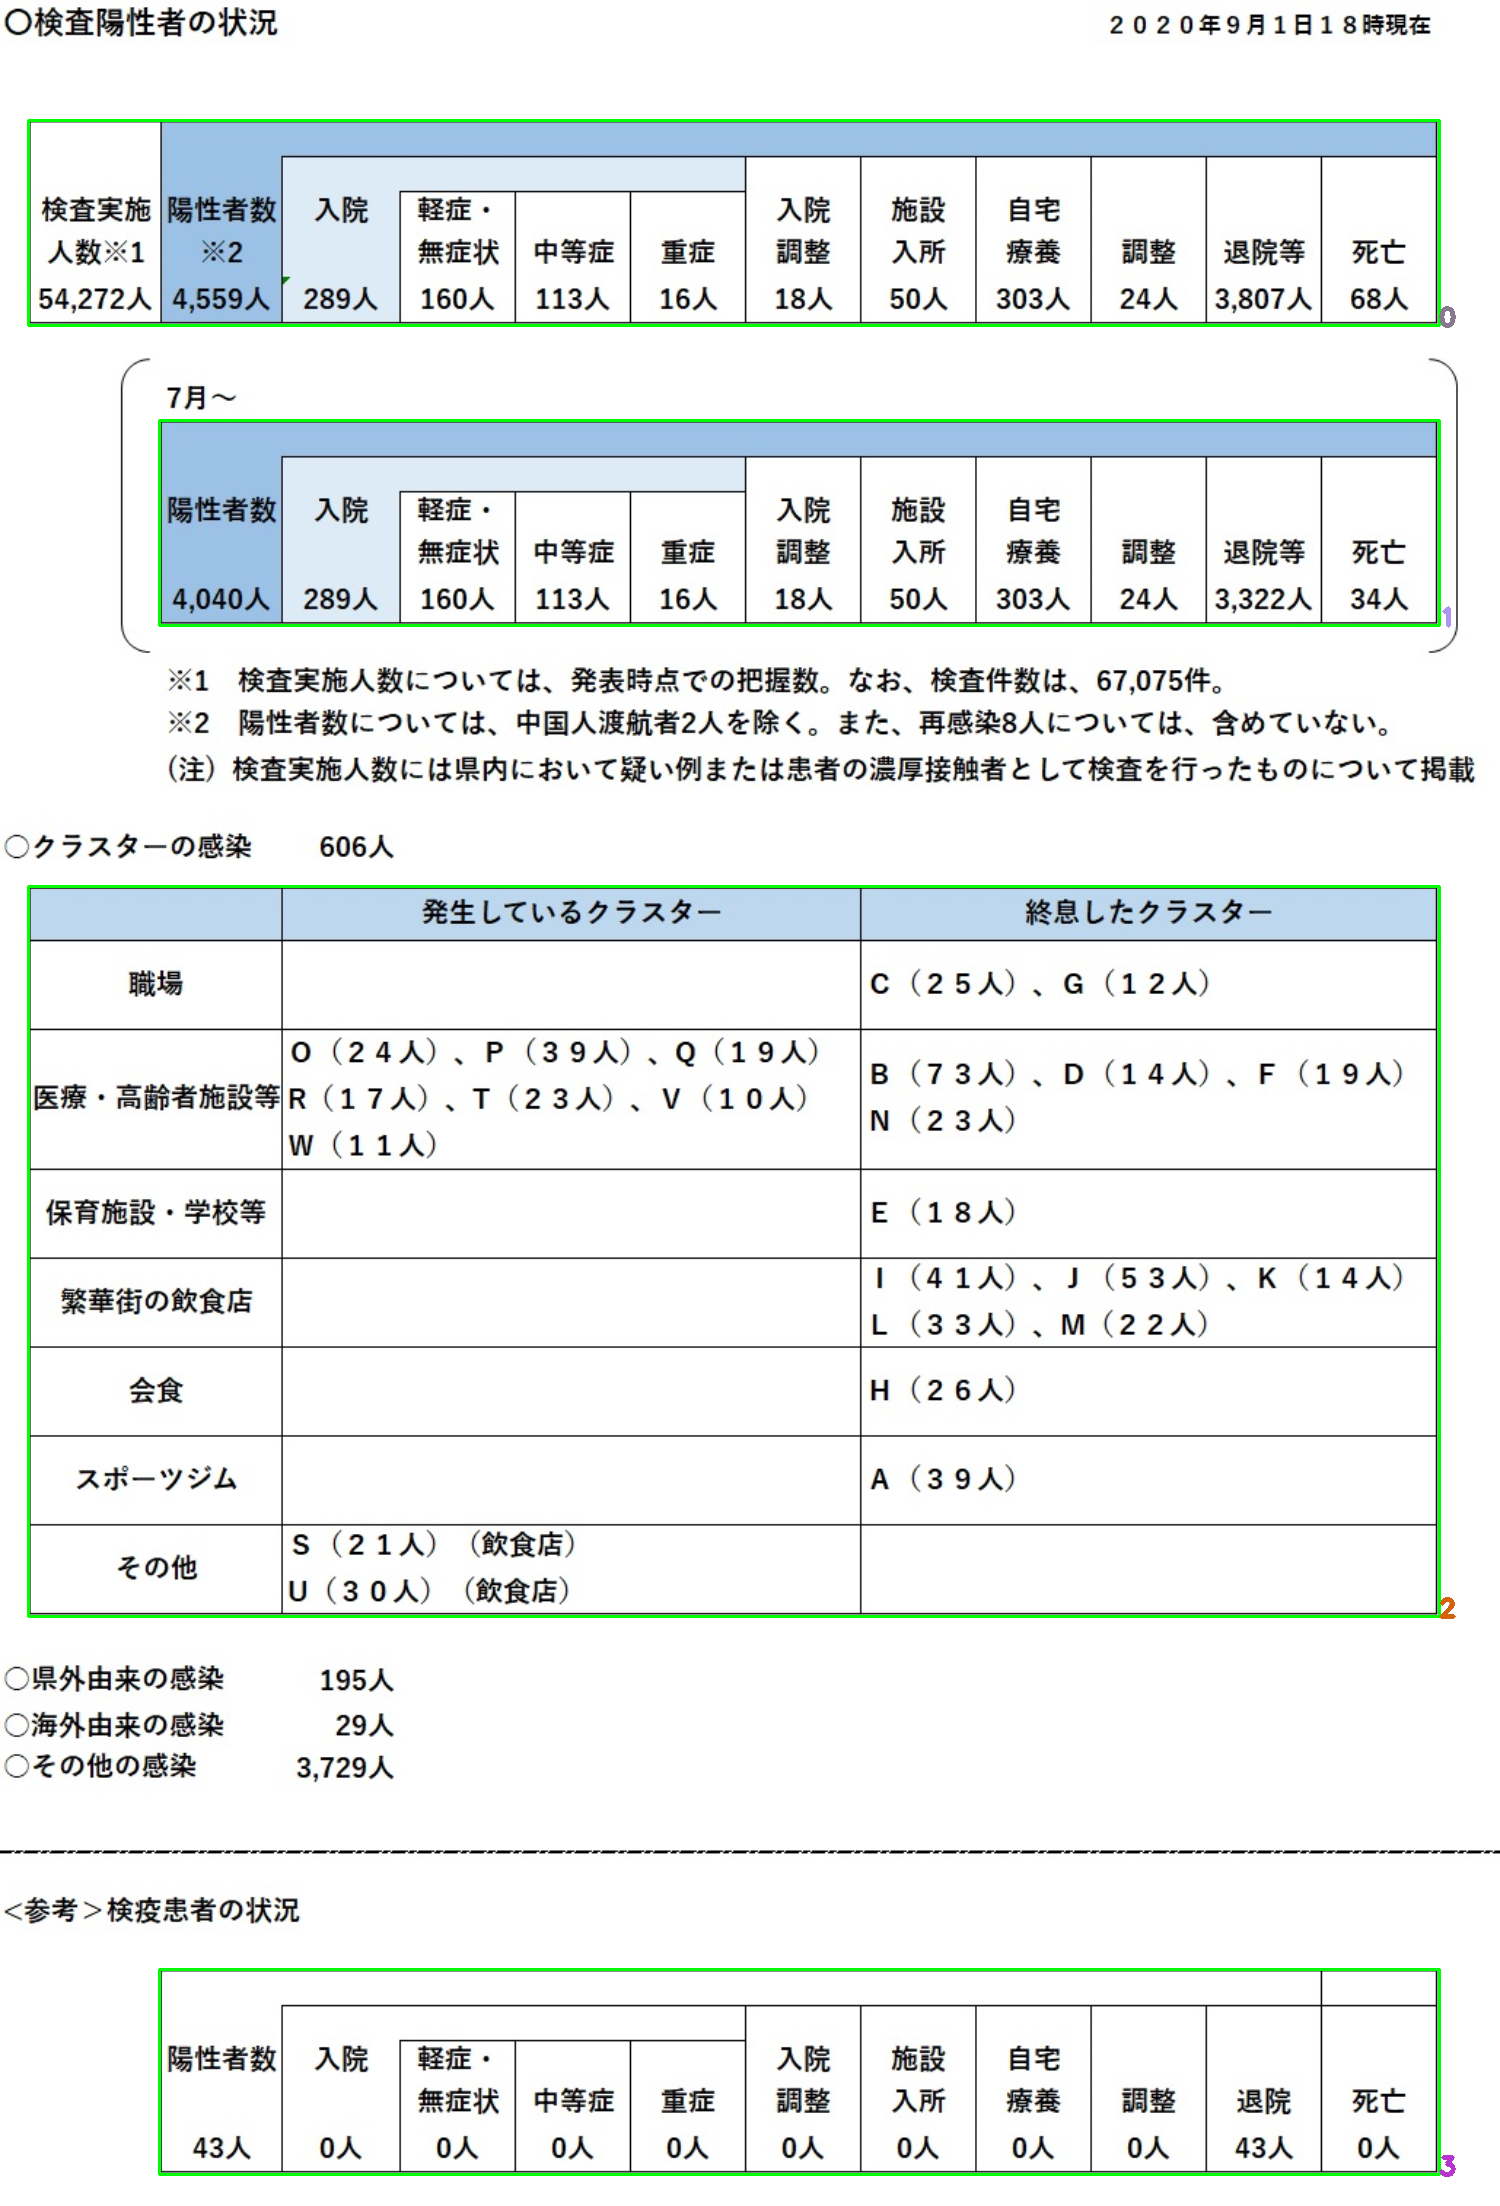

In [16]:
for idx, rect in enumerate(rects):

    x1, x2, y1, y2 = rect

    cv2.rectangle(large, (x1, y1), (x2, y2), (0, 255, 0), 2)
    color = np.random.randint(0, 255, 3).tolist()
    cv2.putText(large, str(idx), (x2, y2), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 3)

cv2_imshow(large)

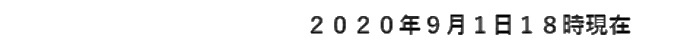

In [17]:
dst = contour[0:50, 800:1500].copy()
cv2_imshow(dst)

In [18]:
txt = (
    pytesseract.image_to_string(dst, lang="jpn", config="--psm 6")
    .strip()
    .replace(".", "")
    .replace(",", "")
)
print(txt)

2020人年9月1日18時現在


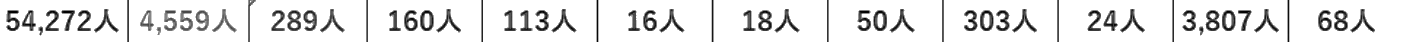

In [19]:
# 座標
x1, x2, y1, y2 = rects[0]

y_crop = int((y2 - y1) * 0.23)

# 切り出し
dst = contour[y1:y2, x1:x2][-y_crop:-5, 5:-5].copy()

cv2_imshow(dst)

In [20]:
edges = cv2.Canny(dst, 100, 200, apertureSize=3)
lines = cv2.HoughLines(edges, 1, np.pi / 2, 30)

# 縦線削除
# theta 角度
for line in lines:
    for rho, theta in line:

        if theta == 0:

            a = np.cos(theta)
            # b = np.sin(theta)

            x0 = int(a * rho)

            x1, x2 = x0, x0
            y1, y2 = 100, -100

            cv2.line(dst, (x1, y1), (x2, y2), (255, 255, 255), 3)

In [21]:
def data_check(text):
    print(text)

    data = list(map(int, re.findall("\d+", text)))
    print(data)

    if(len(data) == 12):
        if data[2] == data[3] + data[4] + data[5]:
            if data[1] == data[2] + data[6] + data[7] + data[8] + data[9] + data[10] + data[11]:
                print("OK")
            else:
                print("陽性者数の集計があいません")
        else:
            print("入院の集計があいません")
    else:
        print("データ数が足りません")

In [22]:
txt = (
    pytesseract.image_to_string(dst, lang="jpn", config="--psm 3")
    .strip()
    .replace(".", "")
    .replace(",", "")
)
data_check(txt)

54272人 4559人 289人 160人 113人 16人 18人 50人 303人 24人 3807人 68人
[54272, 4559, 289, 160, 113, 16, 18, 50, 303, 24, 3807, 68]
OK


In [23]:
txt = (
    pytesseract.image_to_string(dst, lang="jpn", config="--psm 6")
    .strip()
    .replace(".", "")
    .replace(",", "")
)
data_check(txt)

54272人 4559人 289人 160人 113人 16人 18人 50人 303人 24人 3807人 68人
[54272, 4559, 289, 160, 113, 16, 18, 50, 303, 24, 3807, 68]
OK


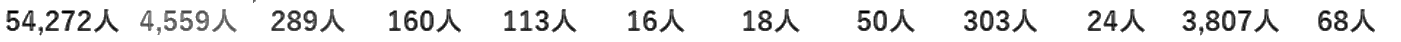

In [24]:
cv2_imshow(dst)

In [25]:
txt = (
    pytesseract.image_to_string(dst, lang="jpn", config="--psm 11")
    .strip()
    .replace(".", "")
    .replace(",", "")
)
data_check(txt)

54272人 4559人 289人

160人

113人

16人

18人

50人

303人

24人 3807人 68人
[54272, 4559, 289, 160, 113, 16, 18, 50, 303, 24, 3807, 68]
OK


In [26]:
cv2.imwrite("main.png", dst)

True